<a href="https://colab.research.google.com/github/Dandelion4ik/CNN/blob/main/FINGER_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download ayuraj/asl-dataset

 97% 55.0M/56.9M [00:00<00:00, 88.4MB/s]
100% 56.9M/56.9M [00:00<00:00, 81.1MB/s]


In [6]:
! unzip asl-dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: asl_dataset/0/hand2_0_dif_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_5_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_5_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_5_cropped.jpeg  
  inflating: asl_

In [7]:
import numpy as np
import cv2 as cv
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense,Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,load_model
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [8]:
train_dir = r'/content/asl_dataset/asl_dataset/'
labels = ['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

In [9]:
# load the images and labels
labels = os.listdir(train_dir)
X_train = []
y_train = []
X_valid = []
y_valid = []

for i, label in enumerate(labels):
    folderpath = train_dir + label + '/'
    for file in os.listdir(folderpath)[0:60]:
        img_path = folderpath + file
        img = cv.imread(img_path)
        img = cv.resize(img, (224, 224))
        X_train.append(np.array(img))
        y_train.append(i)
    for file in os.listdir(folderpath)[60:70]:
        img_path = folderpath + file
        img = cv.imread(img_path)
        img = cv.resize(img, (224, 224))
        X_valid.append(np.array(img))
        y_valid.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(2160, 224, 224, 3)
(2160,)
(355, 224, 224, 3)
(355,)


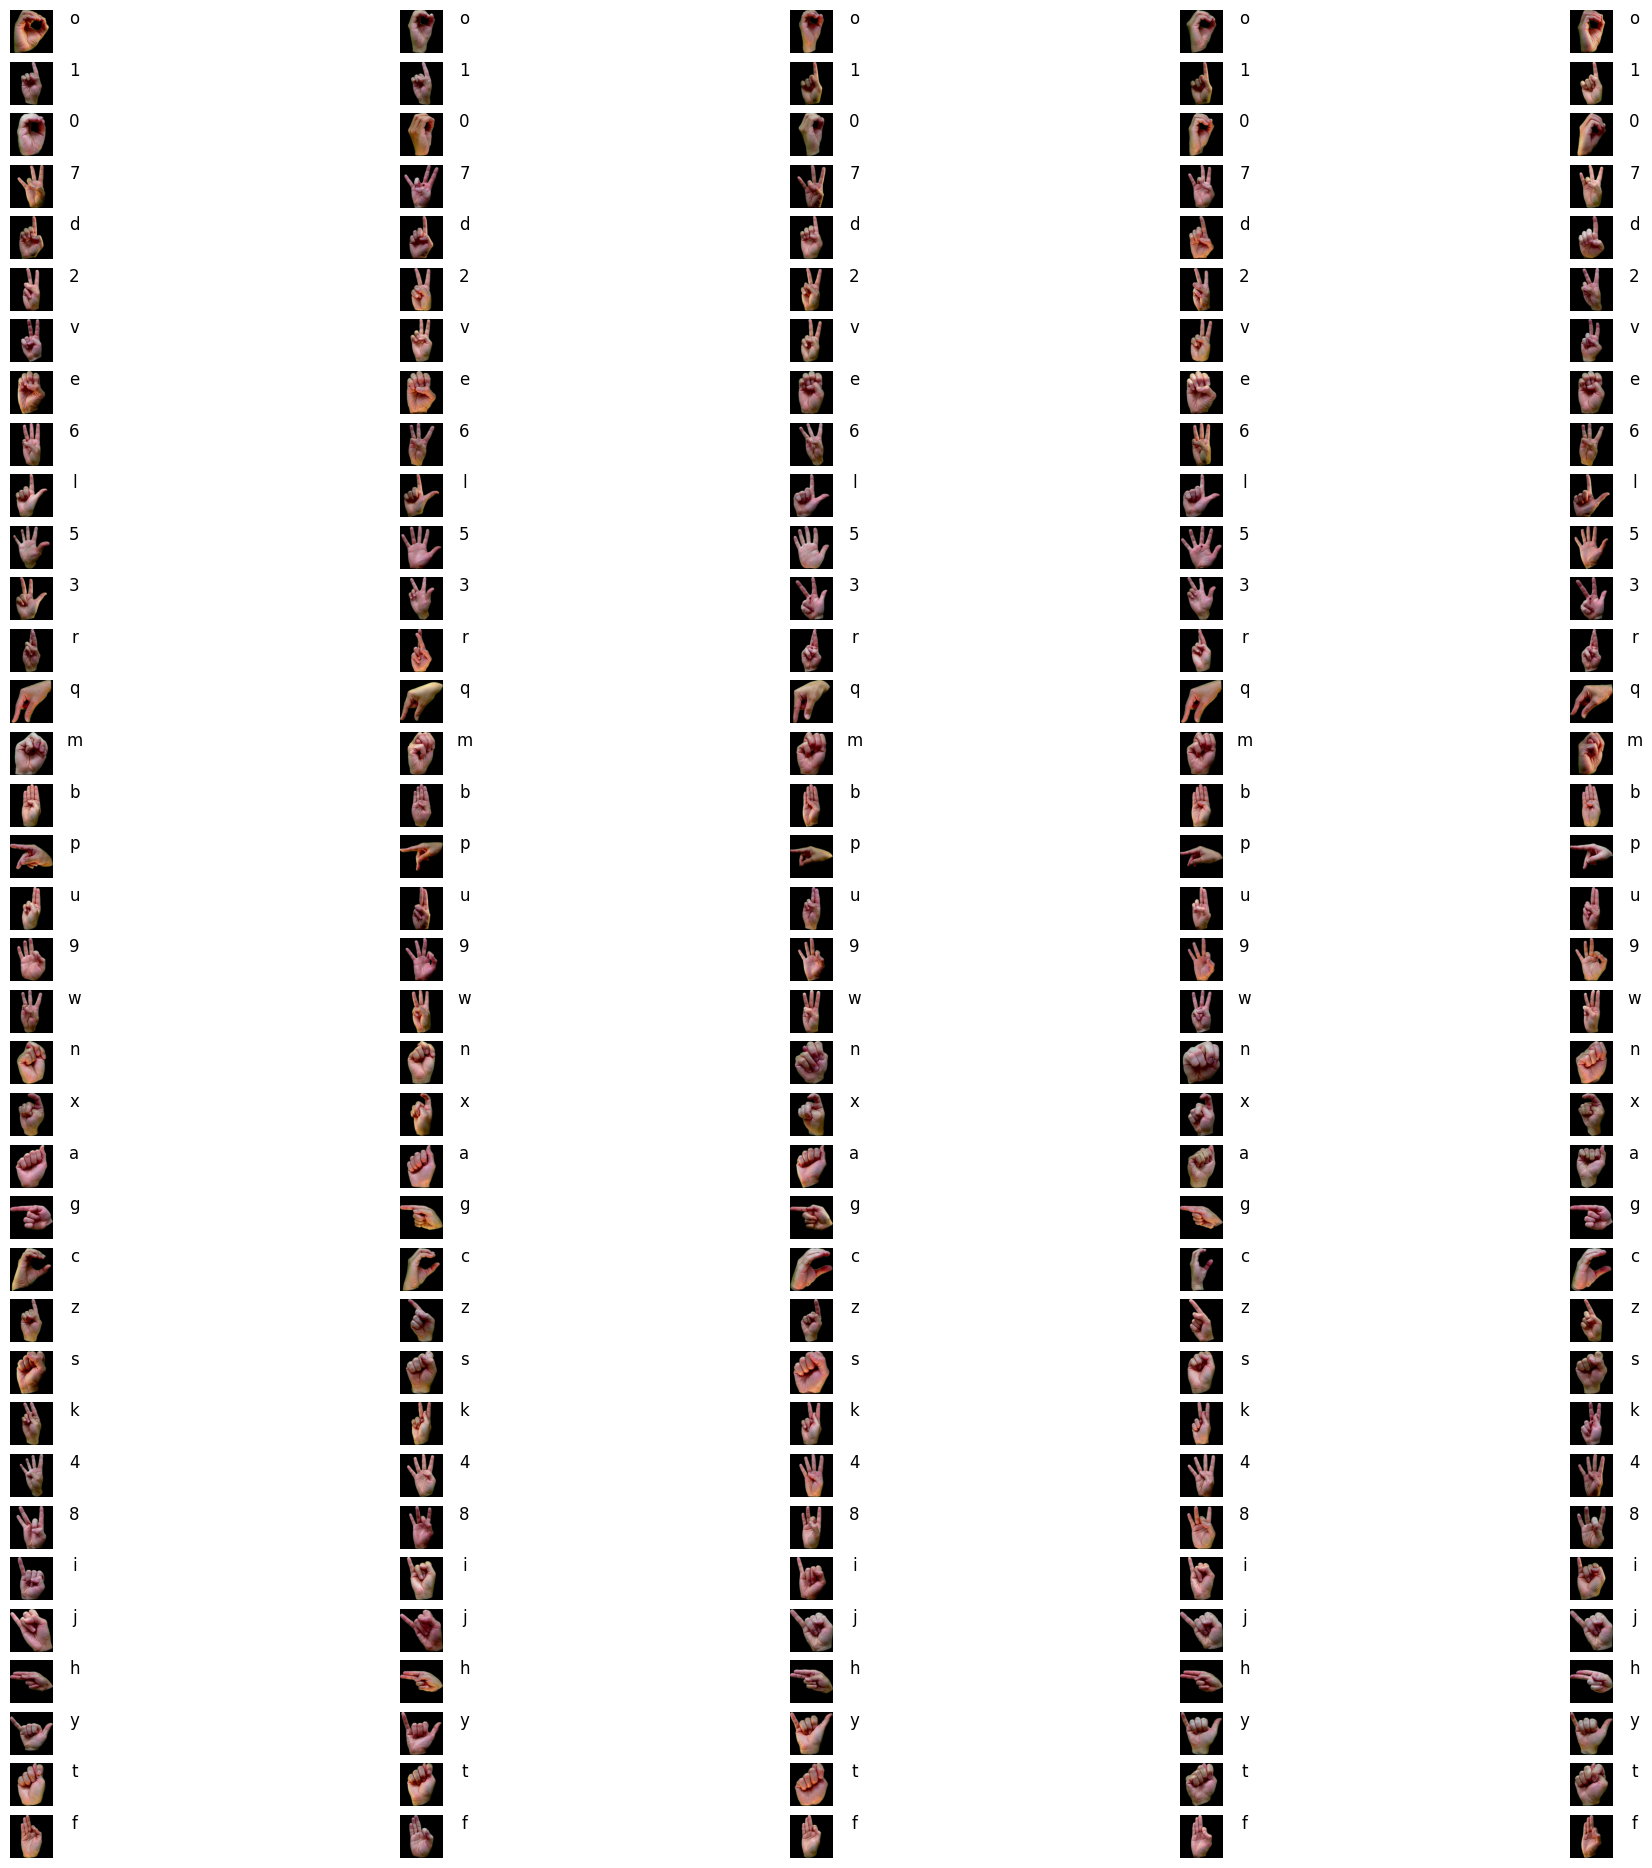

In [10]:
# display 5 random images with their labels
fig, axes = plt.subplots(nrows=len(labels), ncols=5, figsize=(24, 24))
fig.subplots_adjust(wspace=0.3)  # adjust spacing between image and text
for i, label in enumerate(labels):
    folderpath = train_dir + label + '/'
    img_names = os.listdir(folderpath)[:5]
    for j, img_name in enumerate(img_names):
        img_path = folderpath + img_name
        img = plt.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_ylabel(label[:-1], fontsize=14)
        axes[i, j].text(1.5, 0.8, label[-1], fontsize=12, ha='center', va='center', transform=axes[i, j].transAxes)
plt.show()

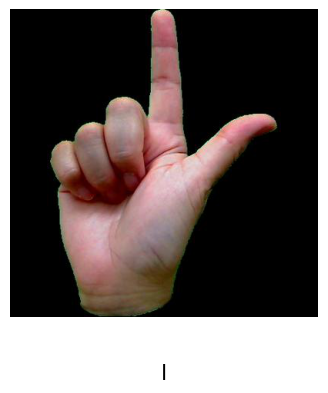

In [11]:
# choose a random label and a random image from the label folder
label = random.choice(labels)  # choose a random label
folderpath = train_dir + label + '/'
img_names = os.listdir(folderpath)[:3]
img_name = random.choice(img_names)  # choose a random image in the folder

# display the image with its label
fig, ax = plt.subplots(figsize=(4, 4))
img_path = folderpath + img_name
img = plt.imread(img_path)
ax.imshow(img)
ax.axis('off')
ax.text(0.5, -0.2, label, fontsize=16, ha='center', transform=ax.transAxes)

plt.show()

In [12]:
# define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')
])

In [13]:
# compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max', verbose=1)

In [15]:
# define the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
stop_loss = 0.17499  # set the stopping loss value

In [16]:
# train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=10,
                    callbacks=[checkpoint, early_stop])

# find the epoch where the stopping loss was reached
loss = history.history['val_loss']
epoch = np.argmax(np.array(loss) <= stop_loss) + 1

Epoch 1/10
68/68 [==============================] - ETA: 0s - loss: 10.3905 - accuracy: 0.2417
Epoch 1: val_accuracy improved from -inf to 0.78028, saving model to best_model.h5
68/68 [==============================] - 278s 4s/step - loss: 10.3905 - accuracy: 0.2417 - val_loss: 0.9933 - val_accuracy: 0.7803
Epoch 2/10
68/68 [==============================] - ETA: 0s - loss: 1.2202 - accuracy: 0.6472
Epoch 2: val_accuracy improved from 0.78028 to 0.89859, saving model to best_model.h5
68/68 [==============================] - 255s 4s/step - loss: 1.2202 - accuracy: 0.6472 - val_loss: 0.3337 - val_accuracy: 0.8986
Epoch 3/10
68/68 [==============================] - ETA: 0s - loss: 0.7300 - accuracy: 0.7634
Epoch 3: val_accuracy improved from 0.89859 to 0.93239, saving model to best_model.h5
68/68 [==============================] - 284s 4s/step - loss: 0.7300 - accuracy: 0.7634 - val_loss: 0.2390 - val_accuracy: 0.9324
Epoch 4/10
68/68 [==============================] - ETA: 0s - loss: 0.5

In [17]:
# load the best model
model = load_model('best_model.h5')

In [18]:
# evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_valid, y_valid, verbose=2)
print('Test accuracy:', test_acc)

12/12 - 11s - loss: 0.1217 - accuracy: 0.9634 - 11s/epoch - 938ms/step
Test accuracy: 0.9633802771568298


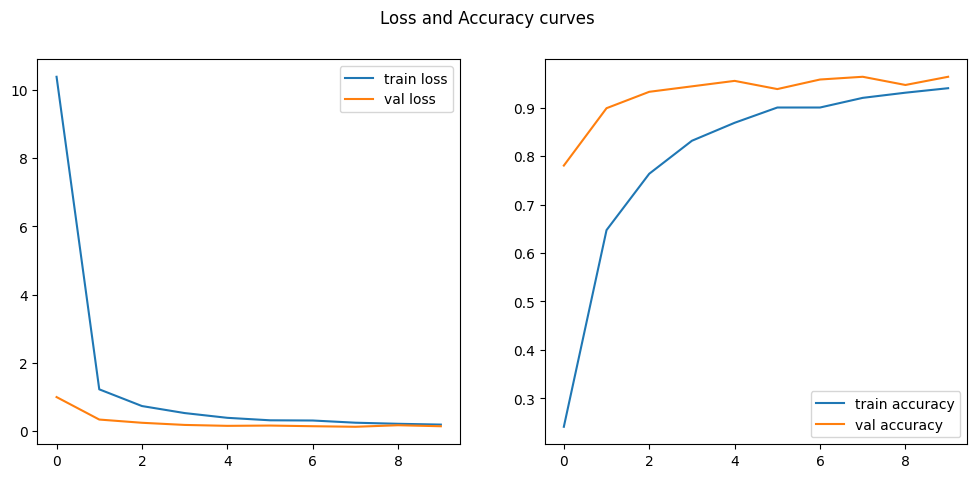

In [19]:
def plot_learning_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Loss and Accuracy curves')
    ax1.plot(loss, label='train loss')
    ax1.plot(val_loss, label='val loss')
    ax1.legend(loc="upper right")
    ax2.plot(accuracy, label='train accuracy')
    ax2.plot(val_accuracy, label='val accuracy')
    ax2.legend()
    plt.show()
    
plot_learning_curves(history)

12/12 [==============================] - 14s 1s/step


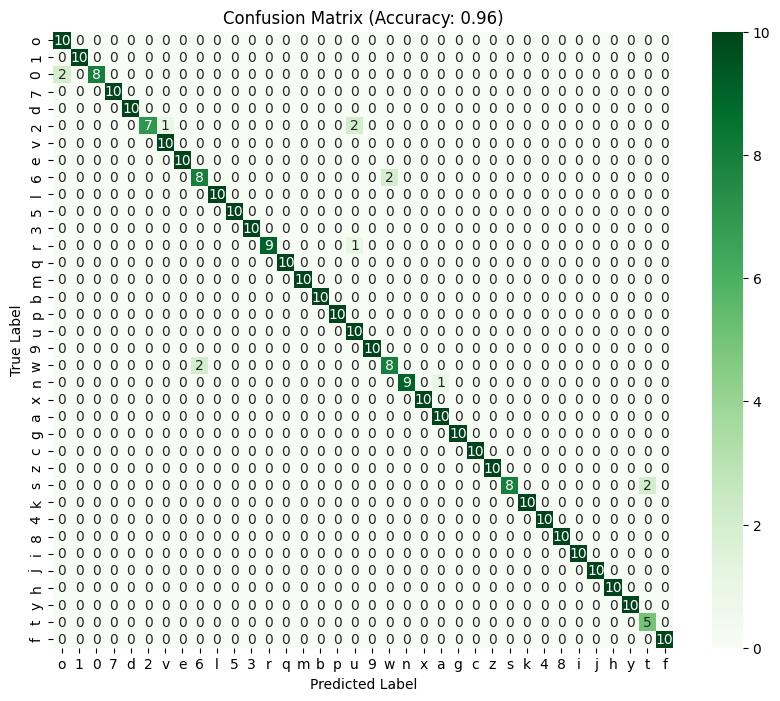

In [20]:
def conf_matrix(model, X_valid, y_valid, labels):
    predictions = model.predict(X_valid)
    y_pred = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(y_valid, y_pred)
    cm = confusion_matrix(y_valid, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap="Greens", fmt=".0f", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix (Accuracy: {accuracy:.2f})")
    plt.savefig("ConfMat.png")
    plt.show()
conf_matrix(model, X_valid, y_valid, labels)

12/12 [==============================] - 11s 918ms/step


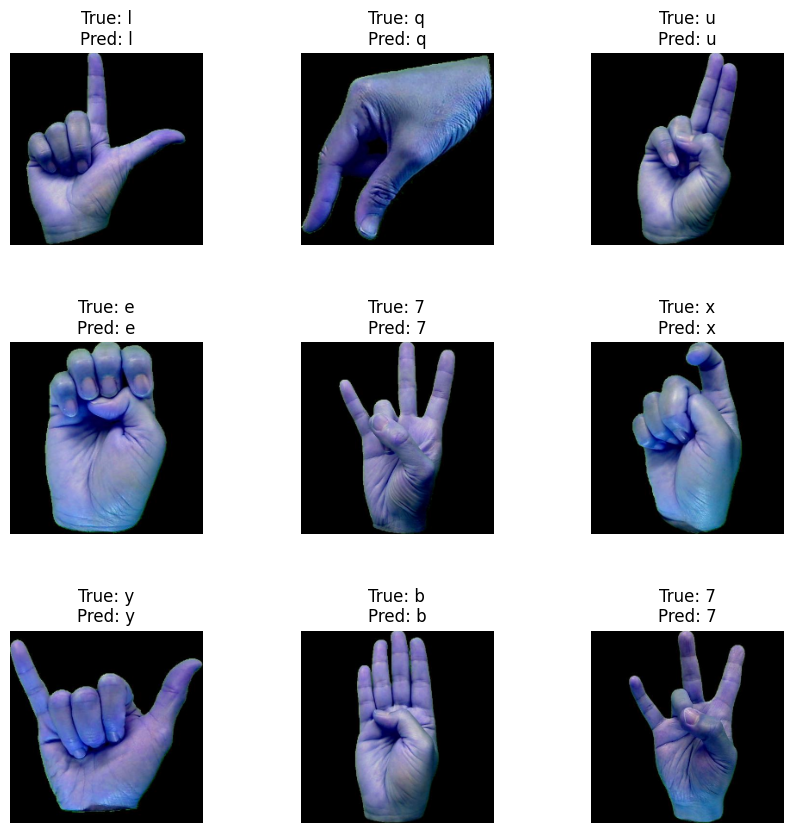

In [21]:
 #get the predicted labels for the test set
y_pred = model.predict(X_valid)
y_pred_labels = np.argmax(y_pred, axis=1)

# display random predictions
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i, ax in enumerate(axs.flat):
    idx = random.randint(0, len(X_valid)-1) # generate a random index
    ax.imshow(X_valid[idx].astype('uint8'))
    ax.set_title(f"True: {labels[y_valid[idx]]}\nPred: {labels[y_pred_labels[idx]]}")
    ax.axis('off')
plt.show()